# Bathymetry data from the Caribbean 

This dataset is a compilation of several single-beam bathymetry surveys downloaded from the [NOAA NCEI](https://ngdc.noaa.gov/mgg/geodas/trackline.html). The data are originally in MGD77 format and include a header with metadata on each survey ([`MGD77_921744.h77t`](MGD77_921744.h77t)).

**License**: Public domain

**Original source**: https://ngdc.noaa.gov/mgg/geodas/trackline.html (region selected from the web interface; no direct download link)

In [25]:
import os
import lzma
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pyproj
import verde as vd
import pooch

## Load and clean the data

The dataset are LZMA compressed and are basically a tab delimited table. We can use pandas to read this directly.

In [2]:
data_full = pd.read_csv(
    "MGD77_921744.m77t.xz", 
    sep="\t", 
    usecols=[0, 4, 5, 9],
    dtype=dict(SURVEY_ID="str", LON="float64", LAT="float64", CORR_DEPTH="float64"),
).dropna().reset_index(drop=True)

Rename the columns to something easier to type, use full names, and include units.

In [3]:
data_full = data_full.rename(columns=dict(SURVEY_ID="survey_id", LAT="latitude", LON="longitude", CORR_DEPTH="depth_m"))
data_full

,survey_id,latitude,longitude,depth_m
0,FM0501,24.77290,-89.58530,3559.0
1,FM0501,24.76070,-89.57550,3561.0
2,FM0501,24.74840,-89.56560,3555.0
3,FM0501,24.73600,-89.55570,3553.0
4,FM0501,24.72380,-89.54580,3553.0
...,...,...,...,...
2354729,EW0003,9.92284,-84.72557,20.0
2354730,EW0003,9.92282,-84.72565,20.0
2354731,EW0003,9.92283,-84.72570,20.0
2354732,EW0003,9.92284,-84.72574,21.0


There is quite a bit of data so we want to slice it a bit to cover a smaller area where the bathymetry is more interesting.

In [22]:
region_latlon = (-88, -59, 7, 24)
data = data_full[vd.inside((data_full.longitude, data_full.latitude), region=region_latlon)].reset_index(drop=True)
data

,survey_id,latitude,longitude,depth_m
0,FM0501,23.13070,-87.99680,75.0
1,FM0501,23.11940,-87.98640,75.0
2,FM0501,23.10810,-87.97610,73.0
3,FM0501,23.09670,-87.96580,73.0
4,FM0501,23.08540,-87.95540,73.0
...,...,...,...,...
1938090,EW0003,9.92284,-84.72557,20.0
1938091,EW0003,9.92282,-84.72565,20.0
1938092,EW0003,9.92283,-84.72570,20.0
1938093,EW0003,9.92284,-84.72574,21.0


Add projected coordinates to the dataset to make it easier to use without having to import pyproj all the time.

In [23]:
proj_string = f"+proj=cea +ellips=WGS84 +lat_ts={np.mean(region_latlon[2:]):.1f} +lon_0={np.mean(region_latlon[:2]):.1f}"
projection = pyproj.Proj(proj_string)
data["easting_m"], data["northing_m"] = projection(data.longitude.values, data.latitude.values)
region = vd.get_region((data.easting_m, data.northing_m))
data

,survey_id,latitude,longitude,depth_m,easting_m,northing_m
0,FM0501,23.13070,-87.99680,75.0,-1.555456e+06,2.583843e+06
1,FM0501,23.11940,-87.98640,75.0,-1.554340e+06,2.582649e+06
2,FM0501,23.10810,-87.97610,73.0,-1.553235e+06,2.581454e+06
3,FM0501,23.09670,-87.96580,73.0,-1.552130e+06,2.580249e+06
4,FM0501,23.08540,-87.95540,73.0,-1.551014e+06,2.579054e+06
...,...,...,...,...,...,...
1938090,EW0003,9.92284,-84.72557,20.0,-1.204464e+06,1.132818e+06
1938091,EW0003,9.92282,-84.72565,20.0,-1.204473e+06,1.132816e+06
1938092,EW0003,9.92283,-84.72570,20.0,-1.204478e+06,1.132817e+06
1938093,EW0003,9.92284,-84.72574,21.0,-1.204483e+06,1.132818e+06


Plot the full data to see what we have.

CPU times: user 248 ms, sys: 26.7 ms, total: 275 ms
Wall time: 269 ms


(801097.9844860577, 2675448.094929717)

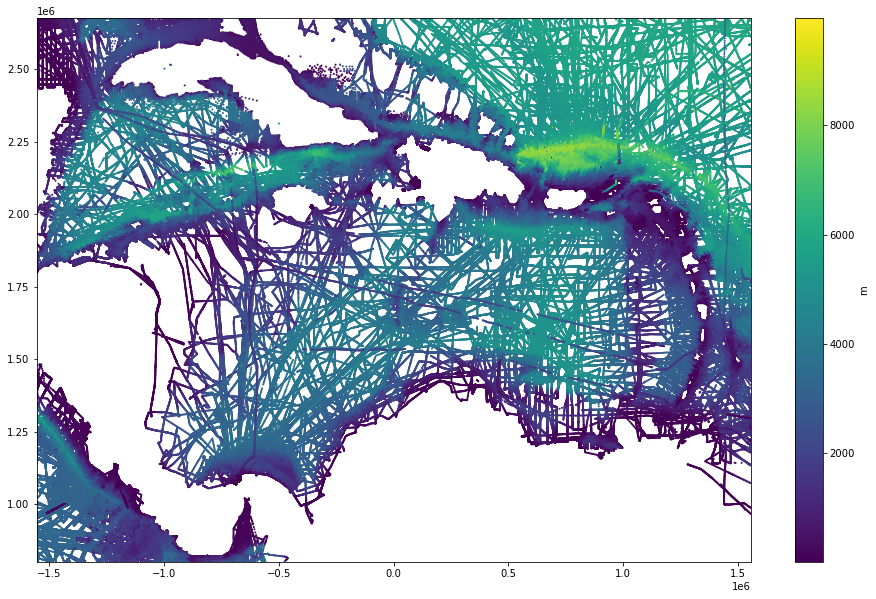

In [24]:
%%time
plt.figure(figsize=(16, 10))
plt.scatter(data.easting_m, data.northing_m, c=data.depth_m, s=1)
plt.colorbar(label="m")
plt.xlim(*region[:2])
plt.ylim(*region[2:])

## Export

Save the data to a file and calculate its size and MD5 hash.

In [27]:
fname = "bathymetry-caribbean.csv"
with open(fname, "w") as output:
    output.write("# meh\n")
    data.to_csv(output, index=False)
print(f"{fname}: md5:{pooch.file_hash(fname, alg='md5')}")
print(f"size: {os.path.getsize(fname) / 1e6} Mb")

bathymetry-caribbean.csv: md5:693547c8793b96dff404b6eb9a55b4db
size: 137.520892 Mb


## Try out some processing

Experiment with some processing functions to see if the results are interesting (for documentation) and can calculte in a reasonable amount of time (suitable for CI).

Block reduce and plot to check how long that would take.

In [5]:
%%time
coords, bathy = vd.BlockReduce(np.median, spacing=0.1).filter((data.LON, data.LAT), data.CORR_DEPTH)
std = vd.BlockReduce(np.std, spacing=0.1).filter((data.LON, data.LAT), data.CORR_DEPTH)[1]
bathy.size

CPU times: user 3.25 s, sys: 39.2 ms, total: 3.29 s
Wall time: 3.3 s


30208

CPU times: user 30.8 ms, sys: 3.34 ms, total: 34.2 ms
Wall time: 29.1 ms


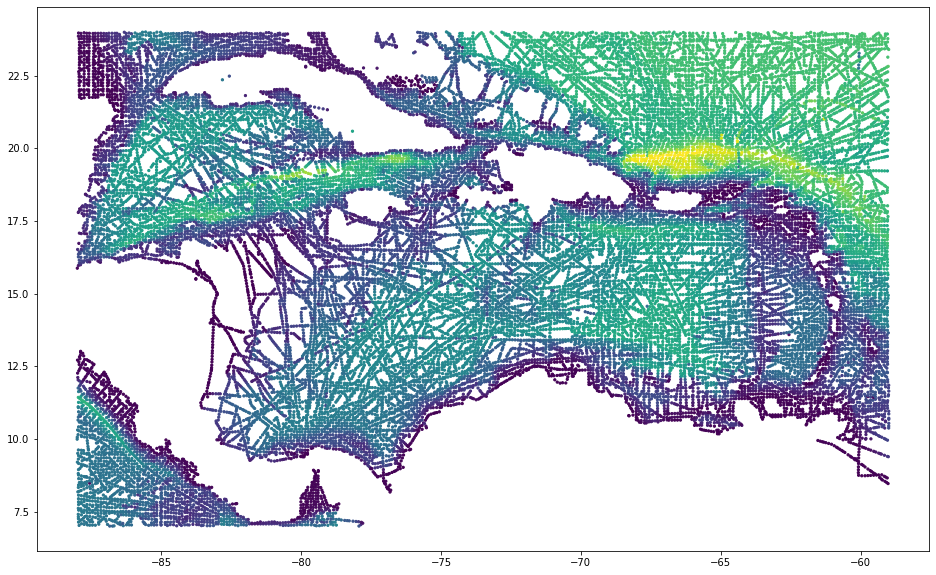

In [6]:
%%time
plt.figure(figsize=(16, 10))
plt.scatter(*coords, c=bathy, s=5)

CPU times: user 157 ms, sys: 3.47 ms, total: 161 ms
Wall time: 154 ms


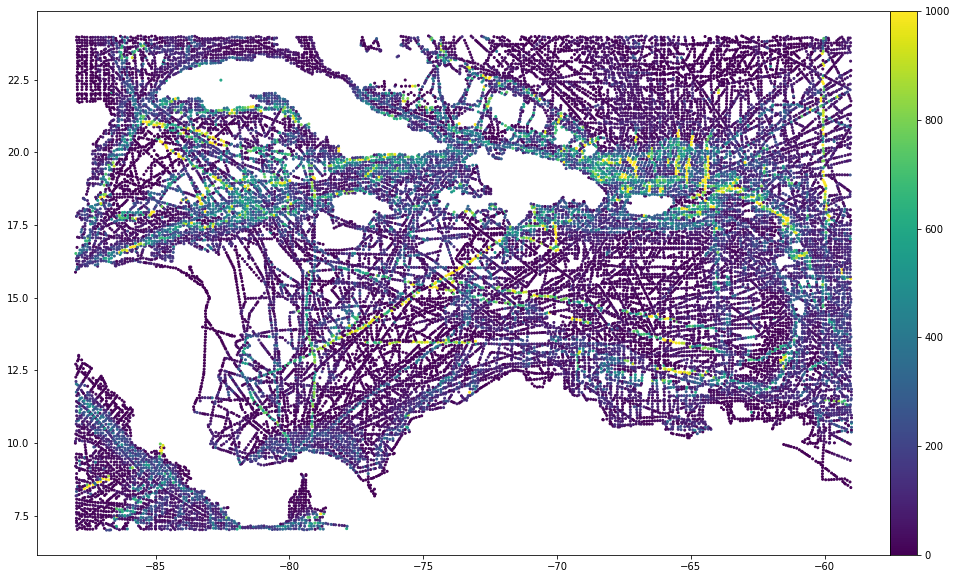

In [7]:
%%time
plt.figure(figsize=(18, 10))
plt.scatter(*coords, c=std, s=4, vmax=1000)
plt.colorbar(pad=0)